In [7]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import impnb
import Data_processing as dp
import ToyQ2
from scipy.optimize import minimize
from functools import partial

git_data='/cndd/hop006/Github/RewardReversalPorject/Data/epoched_eeg'

behavior_log_path='/cndd/hop006/Github/RewardReversalPorject/BehaviorLog/'
Logs=pd.read_pickle(git_data+'/26to38behaviors.pickle')

In [8]:
def myllNEG(action_log,reward_log,params):
    n=len(mya)
    alphaG=params[0]
    alphaL=params[1]
    beta=params[2]
    Q=np.zeros((n,2))
    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
        ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
        -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this
        
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return -np.sum(ll,axis=0)

def myll_log(action_log,reward_log,params):
    n=len(mya)
    alphaG=params[0]
    alphaL=params[1]
    beta=params[2]
    Q=np.zeros((n,2))
    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
        ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
        -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this
        
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return ll,PE,q,Q

def MLE(action_log,reward_log,params0):
    b1=(0.05,1)
    b2=(1,40)
    bnds=(b1,b1,b2)
    cur_myll=partial(myllNEG,mya,myr)
    sol=minimize(cur_myll,params0,method='SLSQP',bounds=bnds)
    return sol

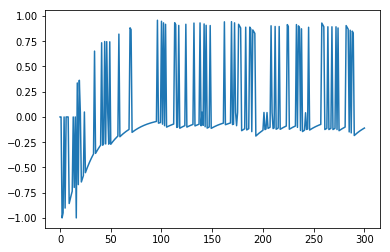

In [9]:
real_params=[0.05,0.02,4]
env=ToyQ2.toyQ_2choice()
rat1=dp.Rat(None,*real_params,init_Q=np.array([0.000001,0.00001]),sim=True)
env,rat1=dp.train_rat(env,rat1,300,sim=True)
plt.plot(rat1.PElog)
mya=rat1.choice_Log
myr=rat1.obsLog

In [11]:
sol=MLE(mya,myr,real_params)
sol

     fun: 321.6505024376245
     jac: array([ 70.11135101,   0.        , 131.19327545])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.05000001, 0.05      , 1.        ])

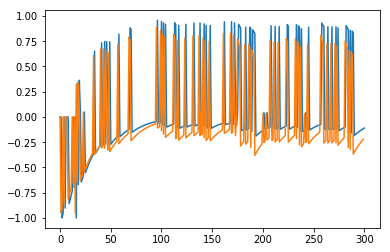

In [12]:
mparams=sol['x']
ll,PE,q,Q=myll_log(mya,myr,mparams)
plt.plot(rat1.PElog)
plt.plot(PE)

# Get all PE logs

33
(288,) (288,)
(290,) (290,)
37
(282,) (282,)
(270,) (270,)
26
(294,) (294,)
(298,) (298,)
28
(285,) (285,)
(294,) (294,)


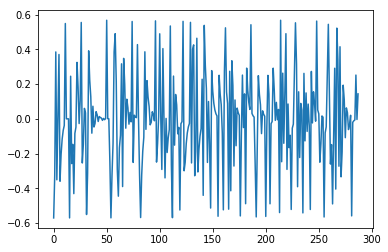

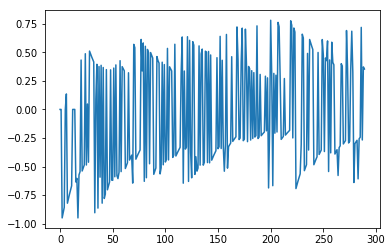

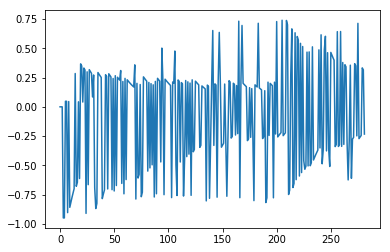

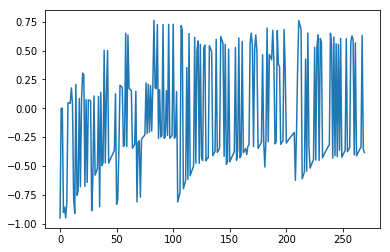

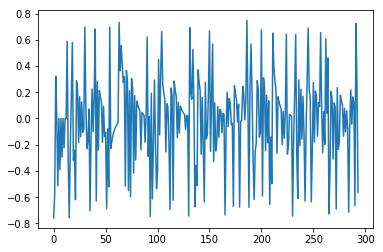

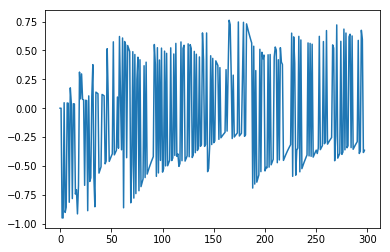

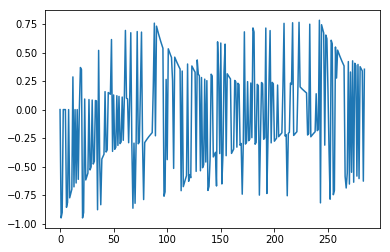

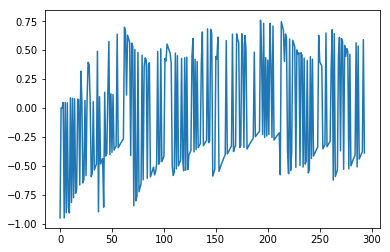

In [27]:
rat_2_anal=[33, 37, 26, 28]
days=2
count=1
PELogs={}
filflag=False

for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        plt.figure(count)
        count+=1
        mya=Logs.loc[flag+'sideaction'][0]
        myr=Logs.loc[flag+'reward'][0]
        print(mya.shape,myr.shape)
        sol=MLE(mya,myr,real_params)
        mparams=sol['x']
        ll,PE,q,Q=myll_log(mya,myr,mparams)
        plt.plot(PE)
        PELogs['rat_'+str(rat)+'day_'+str(day)]=PE
        PELogs['rat_'+str(rat)+'day_'+str(day)+'params']=mparams

In [28]:
PELogs

{'rat_33day_0': array([[-5.69956309e-01],
        [-3.24850194e-01],
        [ 3.84805891e-01],
        [-3.50633764e-01],
        [ 0.00000000e+00],
        [ 3.70110383e-01],
        [-3.59009561e-01],
        [-2.04619764e-01],
        [-1.16624326e-01],
        [-6.64707703e-02],
        [-3.78854349e-02],
        [ 5.48363267e-01],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [-5.69956309e-01],
        [ 2.45106115e-01],
        [-2.57413206e-01],
        [-1.46714281e-01],
        [-4.30256533e-01],
        [-8.36207299e-02],
        [-4.76601626e-02],
        [ 3.24728884e-01],
        [ 1.85081276e-01],
        [-2.71642104e-02],
        [ 1.05488241e-01],
        [ 5.54473896e-01],
        [-2.53930414e-01],
        [-1.44729241e-01],
        [ 6.01236885e-02],
        [ 3.42678756e-02],
        [-5.50425117e-01],
        [-3.13718268e-01],
        [ 3.91150603e-01],
        [ 2.22938754e-01],
        [ 1.27065349e-01],
        [-8.2

In [29]:
PElog_df=pd.Series(PELogs).to_frame('ColumnName')
PElog_df.to_pickle(behavior_log_path+'rat26to38PElog.pkl')